In [1]:
!git clone https://github.com/benjaminpilnick/Stat362-Final-Project-.git
%cd Stat362-Final-Project-
!ls

Cloning into 'Stat362-Final-Project-'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 97 (delta 37), reused 75 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (97/97), 2.88 MiB | 8.49 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/Stat362-Final-Project-
Images	Model_tests  poetry.lock  pyproject.toml  README.md


In [2]:
!mkdir -p Model_tests/GRU

# Setup and Data
We resue the same df_hour preprocessing, splits, scaling and sliding windows as in the other models for consistency.

In [4]:
# Importing
%cd /content/Stat362-Final-Project-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

/content/Stat362-Final-Project-


In [14]:
from tensorflow.keras.optimizers import Adam

In [19]:
from keras.layers import Dropout

In [6]:
df = pd.read_csv('/content/household_power_consumption.txt', sep=';')

numeric_cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.ffill()

df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                format='%d/%m/%Y %H:%M:%S')

df = df.drop(columns=['Date', 'Time'])

df = df.set_index('datetime').sort_index()

df_hour = df.resample('H').mean()

df_hour.head(), df_hour.shape

/tmp/ipython-input-2105978918.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/household_power_consumption.txt', sep=';')
/tmp/ipython-input-2105978918.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour = df.resample('H').mean()


(                     Global_active_power  Global_reactive_power     Voltage  \
 datetime                                                                      
 2006-12-16 17:00:00             4.222889               0.229000  234.643889   
 2006-12-16 18:00:00             3.632200               0.080033  234.580167   
 2006-12-16 19:00:00             3.400233               0.085233  233.232500   
 2006-12-16 20:00:00             3.268567               0.075100  234.071500   
 2006-12-16 21:00:00             3.056467               0.076667  237.158667   
 
                      Global_intensity  Sub_metering_1  Sub_metering_2  \
 datetime                                                                
 2006-12-16 17:00:00         18.100000             0.0        0.527778   
 2006-12-16 18:00:00         15.600000             0.0        6.716667   
 2006-12-16 19:00:00         14.503333             0.0        1.433333   
 2006-12-16 20:00:00         13.916667             0.0        0.0000

In [7]:
df_hour.to_csv('df_hour.csv')

In [8]:
data = pd.read_csv('df_hour.csv', index_col='datetime', parse_dates=['datetime'])

# GRU Models

## Baseline GRU Model

In this section, we build a baseline GRU model for one–step–ahead
forecasting of hourly **Global_active_power**. We reuse the preprocessed
`df_hour` dataset and create a 70/15/15 train–validation–test split,
scale the features, and then create 24-hour sliding windows. The GRU
takes the last 24 hours of data as input and predicts the next hour.

In [11]:
# Copy of the hourly dataset
df = data.copy()

# Train/validation/test split
n = len(df)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train = df.iloc[:train_end]
val   = df.iloc[train_end:val_end]
test  = df.iloc[val_end:]

train.shape, val.shape, test.shape

((24212, 7), (5188, 7), (5189, 7))

In [12]:
# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Using all 7 columns as features
X_cols = df.columns.tolist()
target_col = 'Global_active_power'

# Feature matrices
X_train_raw = train[X_cols]
X_val_raw   = val[X_cols]
X_test_raw  = test[X_cols]

# Target vectors
y_train_raw = train[[target_col]]
y_val_raw   = val[[target_col]]
y_test_raw  = test[[target_col]]

# Fitting scalors
X_train = scaler_X.fit_transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)
X_test  = scaler_X.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)

### Creating sliding windows

We next convert the scaled time series into supervised learning
examples. Each input sample consists of a 24-hour window of past values
for all 7 features, and the target is the **Global_active_power** value
at the next time step.

In [13]:
def create_windows(X, y, look_back=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - look_back):
        X_seq.append(X[i:i+look_back])
        y_seq.append(y[i+look_back])
    return np.array(X_seq), np.array(y_seq)

look_back = 24

X_train_seq, y_train_seq = create_windows(X_train, y_train, look_back)
X_val_seq,   y_val_seq   = create_windows(X_val,   y_val,   look_back)
X_test_seq,  y_test_seq  = create_windows(X_test,  y_test,  look_back)

X_train_seq.shape, y_train_seq.shape

((24188, 24, 7), (24188, 1))

### Baseline GRU architecture

The baseline GRU uses a single GRU layer with 100 units and a Dense output layer.
This serves as the reference model.

Architecture:
Input → GRU(100) → Dense(1)

Training setup:
- Adam optimizer, lr = 0.001
- Loss = MSE
- Early stopping (patience = 5)
- Batch size = 32
- Look-back window = 24 hours

In [15]:
n_features = X_train_seq.shape[2]

gru_model = Sequential([
    Input(shape=(look_back, n_features)),
    GRU(100, return_sequences=False),
    Dense(1)
])

gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100)            │        32,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,801 (128.13 KB)

 Trainable params: 32,801 (128.13 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.4895 - val_loss: 0.3726
Epoch 2/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 0.3727 - val_loss: 0.3588
Epoch 3/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 0.3481 - val_loss: 0.3560
Epoch 4/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.3372 - val_loss: 0.3363
Epoch 5/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.3356 - val_loss: 0.3487
Epoch 6/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.3214 - val_loss: 0.3351
Epoch 7/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 0.3204 - val_loss: 0.3428
Epoch 8/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.3127 - val_loss: 0.3470
Epoch 9/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 0.3081 - val_loss: 0.3413
Epoch 10/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.3011 - val_loss: 0.3498
Epoch 11/30
756/756 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.2895 - val_loss: 0.3413


### Baseline GRU performance

We evaluate the model using RMSE on the train, validation, and test
splits, and then visualize predictions on the first 300 points of
the test set.

In [17]:
def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

# Predictions in scaled space
y_train_pred_s = gru_model.predict(X_train_seq)
y_val_pred_s   = gru_model.predict(X_val_seq)
y_test_pred_s  = gru_model.predict(X_test_seq)

# Inverse-transform to original kW units
y_train_true = scaler_y.inverse_transform(y_train_seq)
y_val_true   = scaler_y.inverse_transform(y_val_seq)
y_test_true  = scaler_y.inverse_transform(y_test_seq)

y_train_pred = scaler_y.inverse_transform(y_train_pred_s)
y_val_pred   = scaler_y.inverse_transform(y_val_pred_s)
y_test_pred  = scaler_y.inverse_transform(y_test_pred_s)

print("GRU RMSE Train:", rmse(y_train_true, y_train_pred))
print("GRU RMSE Val:  ", rmse(y_val_true,   y_val_pred))
print("GRU RMSE Test: ", rmse(y_test_true,  y_test_pred))

756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
GRU RMSE Train: 0.5192375189145917
GRU RMSE Val:   0.5369993160045351
GRU RMSE Test:  0.4677082733771353


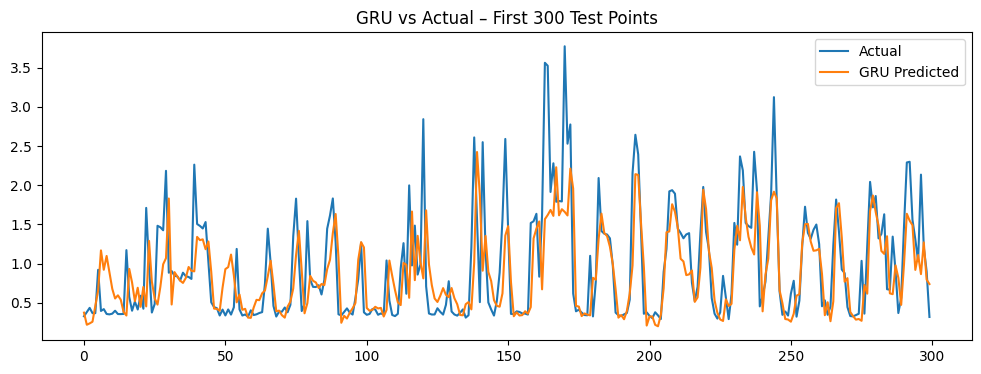

In [18]:
# plotting

plt.figure(figsize=(12,4))
plt.plot(y_test_true[:300], label='Actual')
plt.plot(y_test_pred[:300], label='GRU Predicted')
plt.legend()
plt.title("GRU vs Actual – First 300 Test Points")
plt.show()

The baseline GRU achieves:

- Train RMSE ≈ 0.52  
- Validation RMSE ≈ 0.54  
- Test RMSE ≈ 0.47  

Overall, the model generalizes well, as the validation and test errors remain close to the training error. The prediction plot shows that the GRU captures the main shape and scale of the series, though it still slightly underestimates some of the sharper peaks.

## GRU Variant 1: Dropout and Learning Rate Tuning

This variant adds 0.3 dropout after the GRU layer and reduces the learning rate to 0.0005.

Motivation:
- Dropout helps prevent overfitting
- A smaller learning rate can stabilize convergence

Architecture:
Input → GRU(100) → Dropout(0.3) → Dense(1)

In [20]:
# Building GRU with dropout and smaller LR
gru_dropout = Sequential([
    Input(shape=(look_back, n_features)),
    GRU(100, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

gru_dropout.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
gru_dropout.summary()

history_dropout = gru_dropout.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 100)            │        32,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,801 (128.13 KB)

 Trainable params: 32,801 (128.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.5407 - val_loss: 0.4097
Epoch 2/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.4298 - val_loss: 0.3920
Epoch 3/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.4049 - val_loss: 0.3816
Epoch 4/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.3895 - val_loss: 0.3560
Epoch 5/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.3753 - val_loss: 0.3479
Epoch 6/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.3706 - val_loss: 0.3508
Epoch 7/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.3720 - val_loss: 0.3402
Epoch 8/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.3567 - val_loss: 0.3415
Epoch 9/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.3451 - val_loss: 0.3367
Epoch 10/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.3515 - val_loss: 0.3377
Epoch 11/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.3406 - val_loss: 0.3493
Epoch 12/40
756/756 ━━━━━━━━━━

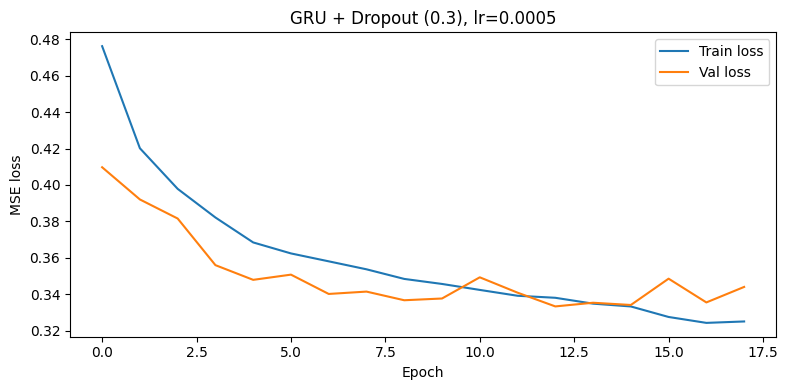

In [21]:
plt.figure(figsize=(8,4))
plt.plot(history_dropout.history["loss"], label="Train loss")
plt.plot(history_dropout.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("GRU + Dropout (0.3), lr=0.0005")
plt.legend()
plt.tight_layout()
plt.show()

The training curve for the GRU + Dropout model shows steady improvement in both the training and validation losses during the first 7–8 epochs. After this point, validation loss flattens and begins to oscillate slightly, while the training loss continues to decrease. This behavior indicates that the model is starting to overfit after around epoch 8. The added dropout helps stabilize validation performance, but it does not significantly improve generalization compared to the baseline GRU model. Early stopping correctly halted training before substantial overfitting occurred.

In [22]:
# Predictions in scaled space
y_train_pred_s_d = gru_dropout.predict(X_train_seq)
y_val_pred_s_d   = gru_dropout.predict(X_val_seq)
y_test_pred_s_d  = gru_dropout.predict(X_test_seq)

# Inverse-transform
y_train_true_d = scaler_y.inverse_transform(y_train_seq)
y_val_true_d   = scaler_y.inverse_transform(y_val_seq)
y_test_true_d  = scaler_y.inverse_transform(y_test_seq)

y_train_pred_d = scaler_y.inverse_transform(y_train_pred_s_d)
y_val_pred_d   = scaler_y.inverse_transform(y_val_pred_s_d)
y_test_pred_d  = scaler_y.inverse_transform(y_test_pred_s_d)

print("GRU + Dropout RMSE Train:", rmse(y_train_true_d, y_train_pred_d))
print("GRU + Dropout RMSE Val:  ", rmse(y_val_true_d,   y_val_pred_d))
print("GRU + Dropout RMSE Test: ", rmse(y_test_true_d,  y_test_pred_d))

756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
GRU + Dropout RMSE Train: 0.5237591295954452
GRU + Dropout RMSE Val:   0.5355806995565403
GRU + Dropout RMSE Test:  0.46864653539831364


Variant 1 RMSE Results:
- Train RMSE: 0.524
- Validation RMSE: 0.536
- Test RMSE: 0.469

The performance is very close to the baseline GRU, indicating that the original model was not overfitting in a significant way. As a result, adding dropout only provided a small amount of regularization and did not noticeably improve the model’s accuracy.

## GRU Variant 2: Stacked GRU Layers

This model increases depth by stacking two GRU layers.
The first GRU returns full sequences, allowing the second GRU to process richer temporal representations.

Motivation:
- Stacking GRUs may help the model learn temporal patterns across multiple time scales.

Architecture:
Input → GRU(64, return_sequences=True) → GRU(32) → Dense(1)

In [23]:
gru_stacked = Sequential([
    Input(shape=(look_back, n_features)),
    GRU(64, return_sequences=True),
    GRU(32, return_sequences=False),
    Dense(1)
])

gru_stacked.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_stacked.summary()

history_stacked = gru_stacked.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 24, 64)         │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,457 (91.63 KB)

 Trainable params: 23,457 (91.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - loss: 0.4988 - val_loss: 0.3766
Epoch 2/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.3799 - val_loss: 0.3579
Epoch 3/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - loss: 0.3483 - val_loss: 0.3526
Epoch 4/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - loss: 0.3405 - val_loss: 0.3289
Epoch 5/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - loss: 0.3329 - val_loss: 0.3320
Epoch 6/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - loss: 0.3280 - val_loss: 0.3386
Epoch 7/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - loss: 0.3126 - val_loss: 0.3383
Epoch 8/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - loss: 0.3100 - val_loss: 0.3395
Epoch 9/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.3089 - val_loss: 0.3271
Epoch 10/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - loss: 0.3004 - val_loss: 0.3349
Epoch 11/40
756/756 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.3005 - val_loss: 0.3430
Epoch 12/40
756/756 ━━━━━━━━━━

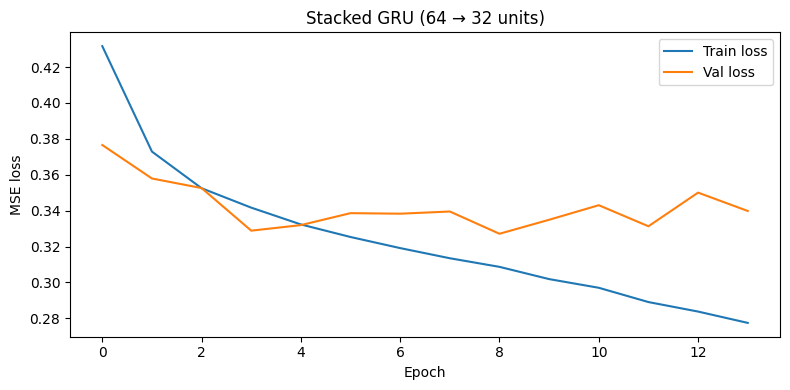

In [24]:
plt.figure(figsize=(8,4))
plt.plot(history_stacked.history["loss"], label="Train loss")
plt.plot(history_stacked.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Stacked GRU (64 → 32 units)")
plt.legend()
plt.tight_layout()
plt.show()

The stacked GRU’s training curve is a lot smoother, and the validation loss levels off pretty quickly with only small ups and downs as training goes on. Compared to the dropout model, the stacked version gets a lower training loss and slightly better validation performance overall. This  means the two-layer GRU is able to learn more detailed patterns without overfitting too much. Even though the validation loss wiggles a bit, the model stays stable and ends up achieving the best RMSE out of all the GRU variants.

In [25]:
# Predictions in scaled space
y_train_pred_s_s = gru_stacked.predict(X_train_seq)
y_val_pred_s_s   = gru_stacked.predict(X_val_seq)
y_test_pred_s_s  = gru_stacked.predict(X_test_seq)

# Inverse-transform
y_train_true_s = scaler_y.inverse_transform(y_train_seq)
y_val_true_s   = scaler_y.inverse_transform(y_val_seq)
y_test_true_s  = scaler_y.inverse_transform(y_test_seq)

y_train_pred_s = scaler_y.inverse_transform(y_train_pred_s_s)
y_val_pred_s   = scaler_y.inverse_transform(y_val_pred_s_s)
y_test_pred_s  = scaler_y.inverse_transform(y_test_pred_s_s)

print("Stacked GRU RMSE Train:", rmse(y_train_true_s, y_train_pred_s))
print("Stacked GRU RMSE Val:  ", rmse(y_val_true_s,   y_val_pred_s))
print("Stacked GRU RMSE Test: ", rmse(y_test_true_s,  y_test_pred_s))

756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Stacked GRU RMSE Train: 0.5022811777235523
Stacked GRU RMSE Val:   0.5305765277340541
Stacked GRU RMSE Test:  0.46544053422801884


Variant 2 RMSE Results:
- Train RMSE: 0.502
- Validation RMSE: 0.531
- Test RMSE: 0.465

This version of the model ended up performing the best out of all the GRU variants. The improvement isn’t huge, but it’s noticeable and shows up consistently across the train, validation, and test sets. That suggests that adding an extra GRU layer helps the model pick up slightly more complex patterns in the data.



## GRU Performance Comparison

Baseline GRU

- Train: 0.519

- Val: 0.537

- Test: 0.468

GRU + Dropout (0.3, lr=0.0005)

- Train: 0.524

- Val: 0.536

- Test: 0.469

Stacked GRU (64 → 32 units)

- Train: 0.502

- Val: 0.531

- Test: 0.465

The stacked GRU achieves the lowest RMSE across all splits.

All three GRU models ended up performing pretty well for this forecasting task, which shows that GRUs are effective at capturing the short-term patterns in the electricity data. The stacked GRU did slightly better than the other two, suggesting that adding an extra recurrent layer helps the model learn a bit more of the underlying structure. On the other hand, adding dropout and lowering the learning rate didn’t make a huge difference, which means the baseline GRU was already generalizing fairly well.